<h1>Project Lab Presentation</h1>

Team members:
    Huyuan Han, Yuqi He, Huaxin Li, Jianhan Wang, Jingwen Wu

Advisors:
    George Zou, Harry Di, Patricia lassus, Roger Lee

## Section 1: Introduction

### Research Goal: Build a trinomial tree option pricing model that ensures non-negative probabilities across the tree.

##### Assumptions: 

1. Underlying price S is martingale. 
2. Local volatility dynamics is a quadratic function of log(St) only (not a function of time).
3. Option type is european plain vanilla option. 

##### Research Approaches:
1. Started from a standard grid tree - deltax is a constant.
   <br>Cons: Must impose constraints on N or on local volatility fuction parameters. 

2. Moved to the direction of using non-constant deltax with fixed upper and lower bounds.
   <br>Pros: Obtained proper probabilities and loosened contraints. 
   <br>Cons: The fixed bounds became new constraints. Probabilities highly depend on the bounds and N. 
   
3. Moved to the direction of using non-constant deltax with dynamic upper and lower bounds. 
   <br>Pros: Easy to obtain stabilized probabilities with few constraints on N.

##### Research Methods:

  1. A: Assume deltax, the unit price increment, is a linear function of local volatility.
     <br>B: Assume deltax, the unit price increment, is a linear function of integral of 1/local volatility.

2. Transform underlying price S to S_tilda, so that S_tilda has a constant local volatility dynamics. 
    

##### Results:

1. Using the pricing model to compute a series of call option prices given a series of strikes.
2. Derived implied volatilities from option prices via BS model.
3. Visualized local volatility and implied volatility as a function of strike price K.
4. Visualized terminal nodes' probability distribution. 
5. Compared results with different local volatility dynamics parameters (skew and kurtosis).

## Section 2: Research Method

In [198]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from collections import deque
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import bisect, brentq

In [199]:
def quad_vol(logS,skew,kurtosis):
    return np.clip(0.2 + skew*(logS - np.log(100)) + kurtosis * (logS - np.log(100)) ** 2,0.01, 1)

Local Volatility Dynamics is defined below:
    
 $$\sigma_{local} = \sigma_{0} + a\cdot(logS - logS_{0}) + b\cdot(logS - logS_{0})^{2}$$
    

##### We assume S0 = 100, sigma0 =0.2, and local voatility has an upper and lower bound of 0.01 and 1, respectively.

### Research Method 1:

Let $\upsilon$ , $\sigma$  and $S_{t}$ be vectors

$$\Delta t = T/N \quad X_{t} = logS_{t} \quad \upsilon = r-0.5\sigma^{2}$$

$$\upsilon \Delta t = P_{u}*(x[:-2] - x[1:-1]) + P_{m}*(x[1:-1] - x[1:-1]) + P_{d}*(x[2:] - x[1:-1])$$

$$(\upsilon \Delta t)^2 + \sigma^2 \Delta t = P_{u}*(x[:-2] - x[1:-1])^2 + P_{m}*(x[1:-1] - x[1:-1])^2 + P_{d}*(x[2:] - x[1:-1])^2$$


Let $U = x[:-2] - x[1:-1]$ and $D = x[2:] - x[1:-1]$


The probabilities arrays are defined below:

$$
     P_{u} = \frac{D \upsilon \Delta t - (\upsilon \Delta t)^2 - \sigma^2 \Delta t}{U(D - U)}
$$

$$
     P_{d} = \frac{-U \upsilon \Delta t + (\upsilon \Delta t)^2 + \sigma^2 \Delta t}{D(D - U)}
$$

$$     
   P_{m} = 1 - (P_{u}+P_{d})
$$
     
To ensure non-negative probabilities, the below condition must be met:

$$
    P_{u} > 0 \quad P_{d} > 0 \quad P_{u} + P_{d} < 1
$$


### Research Method 2: Underlying Price Transformation

Given that: $$\frac{dS}{S} = \sigma(S)dW_t$$
We define a scaled stock price $\tilde{S}$ by: $$\tilde{S} = S_0 \cdot exp\left[c \int_{S_0}^{S} \frac{1}{x\sigma(x)} dx\right]$$
for some constant $c$.

By applying Ito's formula, we have:
$$\mathrm{d} ln \tilde{S} = -\frac{c}{2}(\sigma + \sigma^{'} S)\mathrm{d}t + c\mathrm{d}W_t$$

So,
$$\ln \tilde{S} = \ln S_0 + c \int_{S_0}^{S} \frac{1}{x\sigma(x)} dx $$

Let $y = ln{x}$, therefore,
$$\ln{\tilde{S}_{k+1}} - \ln{\tilde{S}_k} = c \int_{\ln{S_k}}^{\ln{S_{k+1}}} \frac{1}{\sigma(y)} dy$$

Since $ \ln{\tilde{S}_{k+1}} - \ln{\tilde{S}_k}$ is a constant,
$$ \ln{S_{k+1}} - \ln{S_k} \varpropto \frac{1}{avg_{\left[ \ln{S_k}, \ln{S_{k+1}} \right]} \frac{1}{\tilde{\sigma}(y)}}$$

In [200]:
def prob_arr_update(grids, vol, r, T, N,skew, kurtosis):
    deltat = T / N
    sigma = quad_vol(grids[1:-1],skew, kurtosis)
    nu = r - sigma ** 2 / 2
    
    up_arr = grids[:-2] - grids[1:-1] # +deltax
    down_arr = grids[2:] - grids[1:-1]# -delatx 
    
    Pu = (down_arr * nu * deltat - (nu * deltat) ** 2 - sigma ** 2 * deltat) / up_arr / (down_arr - up_arr)
    Pd = (-up_arr * nu * deltat + (nu * deltat) ** 2 + sigma ** 2 * deltat) / down_arr / (down_arr - up_arr)
    Pm = 1 - Pu - Pd
    
    return (Pu, Pd, Pm)

#### Research Method 1-A：Assume deltax, the unit price increment, is a linear function of local volatility.

In [201]:
def dynamic_integral_grids_2(vol, S0, T, N, r,skew,kurtosis):
    grids = deque()
    center = np.log(S0)
    grids.append(center)
    deltat = T / N 
    initial_deltax = vol(center,skew,kurtosis) * np.sqrt(2 * deltat) ## THIS NUMBER MATTERS 

    
    deltax_up,deltax_down = initial_deltax,initial_deltax
    center_up,center_down = center,center
    for i in range(N):
        next_up = center_up + deltax_up
        next_down = center_down - deltax_down
        grids.appendleft(next_up)
        grids.append(next_down)
        center_up = next_up
        deltax_up = vol(center_up,skew,kurtosis) * np.sqrt(2 * deltat)
        center_down = next_down
        deltax_down = vol(center_down,skew,kurtosis) * np.sqrt(2 * deltat)   

        
    full_grids = np.array(grids)
    sigma = vol(full_grids[1:-1],skew,kurtosis)
    nu = r - sigma ** 2 / 2
    
    up_arr = full_grids[:-2] - full_grids[1:-1]
    down_arr = full_grids[2:] - full_grids[1:-1]
    
    indicator = 1 - (-(up_arr + down_arr) * nu * deltat + (nu * deltat) ** 2 + sigma ** 2 * deltat) / (-up_arr * down_arr) 
    # indicator is pm.
    pm_min = min(indicator)
    return (pm_min, full_grids)

#### Research Method 1-B：Assume deltax, the unit price increment, is a linear function of integral of 1/local volatility.

In [202]:
def dynamic_integral_grids(vol, S0, T, N, r,skew,kurtosis):
    grids = deque()
    center = np.log(S0)
    grids.append(center)
    deltat = T / N
    initial_step = vol(center,skew,kurtosis) * np.sqrt(2 * deltat) ## THIS NUMBER MATTERS
    # this is the initial deltax. 
    reference = quad(lambda x: 1 / vol(x,skew,kurtosis), center, center + initial_step)[0]
    
    
    next_up = center
    for i in range(N):
        next_up = brentq(lambda x: quad(lambda y: 1 / vol(y,skew,kurtosis), next_up, x)[0] - reference, next_up, next_up + 1.1 * reference)
        grids.appendleft(next_up)
        
    next_down = center
    for j in range(N):
        next_down = brentq(lambda x: quad(lambda y: 1 / vol(y,skew,kurtosis), x, next_down)[0] - reference, next_down - 1.1 * reference, next_down)
        grids.append(next_down)
        
    full_grids = np.array(grids)
    sigma = vol(full_grids[1:-1],skew,kurtosis)
    nu = r - sigma ** 2 / 2
    
    up_arr = full_grids[:-2] - full_grids[1:-1]
    down_arr = full_grids[2:] - full_grids[1:-1]
    
    indicator = 1 - (-(up_arr + down_arr) * nu * deltat + (nu * deltat) ** 2 + sigma ** 2 * deltat) / (-up_arr * down_arr)
    pm_min = min(indicator)
    return (pm_min, full_grids)

In [203]:
def BS_call_price(sigma, S0, r, K, T):
    F0 = S0 * np.exp(r * T)
    sd = sigma * np.sqrt(T)
    d1 = np.log(F0 / K) / sd + sd / 2
    d2 = np.log(F0 / K) / sd - sd / 2
    return np.exp(-r * T) * (F0 * norm.cdf(d1) - K * norm.cdf(d2))

def IV_call(C, S0, r, K, T): #brentq solve for IV. 
    lowerbound = np.max([0, S0 - K * np.exp(-r * T)])
    if C < lowerbound:
        return np.nan
    elif C >= S0:
        return np.nan
    elif C == lowerbound:
        return 0
    
    high = 0.2
    while BS_call_price(high, S0, r, K, T) > C:
        high = high / 2
    
    while BS_call_price(high, S0, r, K, T) < C:
        high = high * 2
        
    low = high / 2
    implied_vol = brentq(lambda x: BS_call_price(x, S0, r, K, T) - C, low, high)
    return implied_vol

def IV_curve_call(grids, vol, r, K_arr, T, N,skew,kurtosis):
    if len(grids) != (2 * N + 1):
        print("invalid grids!")
    
    (Pu, Pd, Pm) = prob_arr_update(grids, vol, r, T, N,skew,kurtosis)
    ST = np.exp(grids)
    deltat = T / N
    price_records = []
    IV_records = []
    
    for i in range(len(K_arr)):
        euro = np.maximum(ST - K_arr[i], 0)
        euro = np.exp(-r * deltat) * (Pu * euro[:-2] + Pm * euro[1:-1] + Pd * euro[2:])
        for j in range(1, N):
            euro = np.exp(-r * deltat) * (Pu[j:-j] * euro[:-2] + Pm[j:-j] * euro[1:-1] + Pd[j:-j] * euro[2:])
            
        if len(euro) != 1:
            print("wrong dimension")
            
        current_price = euro[0]
        current_IV = IV_call(current_price, ST[N], r, K_arr[i], T)
        
        price_records.append(current_price)
        IV_records.append(current_IV)
        
    return (np.array(price_records), np.array(IV_records))

In [204]:
def final_logS(grids, vol, T, N, r,skew,kurtosis):
    (Pu, Pd, Pm) = prob_arr_update(grids, vol, r, T, N,skew,kurtosis)
    prob_flow = np.array([1])
    for i in range(N):
        up_flow = np.concatenate([Pu[(N-1-i):(N+i)] * prob_flow, [0, 0]])
        mid_flow = np.concatenate([[0], Pm[(N-1-i):(N+i)] * prob_flow, [0]])
        down_flow = np.concatenate([[0, 0], Pd[(N-1-i):(N+i)] * prob_flow])
        prob_flow = up_flow + mid_flow + down_flow
    return prob_flow

In [205]:
def normalized_prob(prob_flow,nodes,skew,kurtosis):
    
    prob_flow = prob_flow[1:-1]
    nodes_distance = nodes[:-1]-nodes[1:]
    mid_distance = (nodes_distance[:-1]+nodes_distance[1:])/2
    nor_prob = prob_flow/mid_distance
  
    return nor_prob

## Section 3.1 - Method 1-A & 1-B
###  Inital Results:  Set skew = -0.1, kurtosis = 0

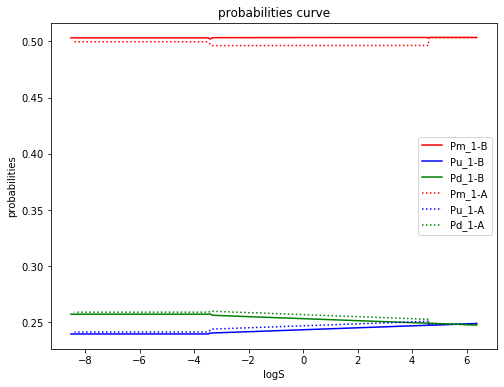

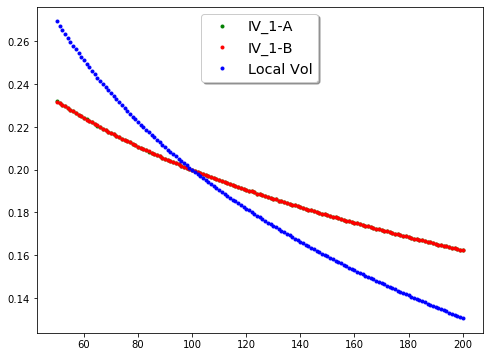

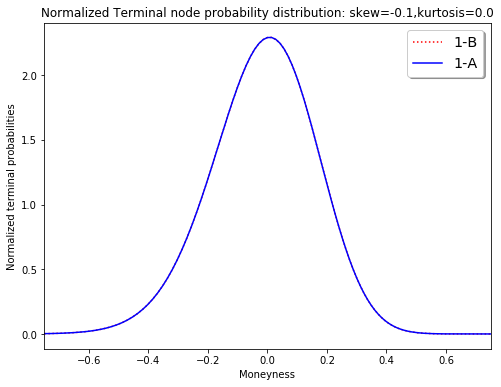

In [206]:
vol, S0, T, N, r,skew, kurtosis = quad_vol, 100, 0.75, 300, 0, -0.1, 0
(quad_pm, quad_grids) = dynamic_integral_grids(vol, S0, T, N, r,skew, kurtosis)
(quad_pm_2, quad_grids_2) = dynamic_integral_grids_2(vol, S0, T, N, r,skew, kurtosis)

K = np.linspace(50, 200, 151)
grids1= quad_grids
(quad_price, quad_IV) = IV_curve_call(grids1, vol, r, K, T, N, skew, kurtosis)
grids2 = quad_grids_2
(quad_price_2, quad_IV_2) = IV_curve_call(grids2, vol, r, K, T, N, skew, kurtosis)


fig, ax1 = plt.subplots(figsize=(8,6))
prop_prob_2 = prob_arr_update(quad_grids_2, vol, r, T, N,skew, kurtosis)
prop_prob = prob_arr_update(quad_grids, vol, r, T, N,skew, kurtosis)
ax1.plot(quad_grids[1:-1], prop_prob[2], 'r', label = 'Pm_1-B')
ax1.plot(quad_grids[1:-1], prop_prob[0], 'b', label = 'Pu_1-B')
ax1.plot(quad_grids[1:-1], prop_prob[1], 'g', label = 'Pd_1-B')
ax1.plot(quad_grids_2[1:-1], prop_prob_2[2], 'r:', label = 'Pm_1-A')
ax1.plot(quad_grids_2[1:-1], prop_prob_2[0], 'b:', label = 'Pu_1-A')
ax1.plot(quad_grids_2[1:-1], prop_prob_2[1], 'g:', label = 'Pd_1-A')
plt.ylabel('probabilities')
plt.xlabel('logS')
plt.title('probabilities curve')
plt.legend()

fig, ax2 = plt.subplots(figsize=(8,6))
ax2.plot(K, quad_IV_2, 'g.',label = 'IV_1-A')
ax2.plot(K, quad_IV, 'r.',label = 'IV_1-B')
ax2.plot(K, quad_vol(np.log(K),skew, kurtosis), 'b.',label = 'Local Vol')
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')


prob_flow,nodes = final_logS(quad_grids, vol, T, N, r,skew, kurtosis),quad_grids
nor_prob = normalized_prob(prob_flow,nodes,skew,kurtosis)
prob_flow2,nodes2 = final_logS(quad_grids_2, vol, T, N, r,skew, kurtosis),quad_grids_2
nor_prob2 = normalized_prob(prob_flow2,nodes2,skew,kurtosis)

fig, ax4 = plt.subplots(figsize=(8,6))
ax4.plot(quad_grids[1:-1]-np.log(100), nor_prob,'r:',label = '1-B') # pr1/sum(pr1*detlax)
ax4.plot(quad_grids_2[1:-1]-np.log(100), nor_prob2,'b', label = '1-A')
plt.xlim(-0.75, 0.75)
plt.ylabel('Normalized terminal probabilities')
plt.xlabel('Moneyness')
plt.title("Normalized Terminal node probability distribution: skew=%.1f,kurtosis=%.1f"%(skew,kurtosis))
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')


### Observation:
Recall the local volatility dynamics:
    
 $$\sigma_{local} = \sigma_{0} + a\cdot(logS - logS_{0}) + b\cdot(logS - logS_{0})^{2}$$
 We assume S0 = 100, sigma0 =0.2, and local voatility has an upper and lower bound of 0.01 and 1, respectively.

1. As logS increases, probabilities remained very stable. Method 1-B's distribution is smoother.
2. IV curve is smooth and is relatively flattened compared to local vol. The two sub-methods have nearly identical distribution.
3. Node distribution is showing negative skewness. The two sub-methods are nearly identical distribution.

## Section 3.2 - Method 2
###  Inital Results:  Set skew = -0.1, kurtosis = 0

In [207]:
def quad_vol1(logS,skew,kurtosis): #initialize parameters
    return np.clip(0.2 + skew*(logS - np.log(100)) + kurtosis * (logS - np.log(100)) ** 2,0.01, 1)

In [208]:
def prob_arr(grids, r, T, N, skew,kurtosis):
    deltat = T / N
    sigma = quad_vol1(grids[1:-1],skew,kurtosis) #initial and terminal don't account for sigma.  
    nu = r - sigma ** 2 / 2
    
    up_arr = grids[:-2] - grids[1:-1]
    down_arr = grids[2:] - grids[1:-1]
    
    Pu = (down_arr * nu * deltat - (nu * deltat) ** 2 - sigma ** 2 * deltat) / up_arr / (down_arr - up_arr)
    Pd = (-up_arr * nu * deltat + (nu * deltat) ** 2 + sigma ** 2 * deltat) / down_arr / (down_arr - up_arr)
    Pm = 1 - Pu - Pd
    
    return (Pu, Pd, Pm)

In [209]:
def integral(lower,upper,skew,kurtosis):
    return (quad(lambda x:1/quad_vol1(x,skew,kurtosis),lower,upper,args=())[0])

In [210]:
def findSlimit(logStilde,x,skew,kurtosis):
    return logStilde-np.log(100)-c*integral(np.log(100),x,skew,kurtosis)

In [211]:
def proportional_grids(vol, U, L, T, N, r, loop, c, skew,kurtosis):
    current_full = np.linspace(U, L, 2 * N + 1) #terminal state logS grid
    record_positive = []
    record_entropy = []
    for i in range(loop):
        grid_interval=[]
        for i in range(2 * N):
            grid_interval.append(1/(integral(current_full[i+1],current_full[i],skew,kurtosis)/(current_full[i]-current_full[i+1])))
        temp_grids = U - (U - L) * np.cumsum(grid_interval)/ np.sum(grid_interval)
        current_full = np.concatenate([[U], temp_grids])
        
        interval_width = current_full[:-1] - current_full[1:]
        entropy = np.sum(-interval_width * np.log(interval_width))
        record_entropy.append(entropy)

        sigma = vol(current_full[1:-1], skew,kurtosis)
        nu = r - sigma ** 2 / 2
        
        up_arr = current_full[:-2] - current_full[1:-1]
        down_arr = current_full[2:] - current_full[1:-1]
        
        indicator = (-(up_arr + down_arr) * nu * deltat + (nu * deltat) ** 2 + sigma ** 2 * deltat) / (-up_arr * down_arr) - 1
        
        record_positive.append(np.max(indicator))
    
    return (np.array(record_entropy), np.array(record_positive), current_full)

* Using the transformation, we can calculate the upper bound and lower bound by integral.

In [212]:
T,N,r,loop,c,skew,kurtosis = 0.75,100,0,200,0.2,-0.1,0
deltat=T/N
U=fsolve(lambda x:findSlimit(np.log(100)+N*c*np.sqrt(2*deltat),x,skew,kurtosis), 10)[0]
L=fsolve(lambda x:findSlimit(np.log(100)-N*c*np.sqrt(2*deltat),x,skew,kurtosis), 0)[0]
print(U,L,np.log(100))

6.017504874232121 -0.20142520084293591 4.605170185988092


* Upper and lower bound by method 2

In [213]:
U,L,np.log(100)

(6.017504874232121, -0.20142520084293591, 4.605170185988092)

* Upper and lower bound by method 1

In [214]:
grids1[0],grids1[-1],np.log(100)

(6.367223516193148, -8.589009564211272, 4.605170185988092)

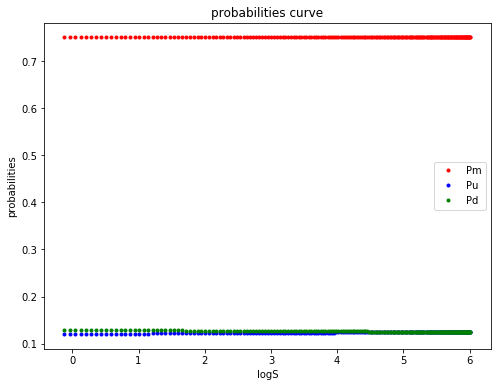

In [215]:
(test_entropy, test_positive, test_grids) = proportional_grids(quad_vol1,U,L,T,N,r,loop,c,skew,kurtosis)
prop_prob = prob_arr(test_grids, 0, 0.75,200,skew,kurtosis)
plt.figure(figsize = (8, 6))
plt.plot(test_grids[1:-1], prop_prob[2], 'r.', label = 'Pm')
plt.plot(test_grids[1:-1], prop_prob[0], 'b.', label = 'Pu')
plt.plot(test_grids[1:-1], prop_prob[1], 'g.', label = 'Pd')

plt.ylabel('probabilities')
plt.xlabel('logS')
plt.title('probabilities curve')
plt.legend()

In [216]:
def optionPricer(K,X,prob):
    option_price=np.maximum(np.exp(X)-K,0) 
    Pu=prob[0]
    Pd=prob[1]
    Pm=prob[2]
    for t in np.linspace(N-1, 0, num=N, endpoint=True)*deltat:
        option_price = np.exp(-r*deltat)*(Pu*option_price[:-2]+Pm*option_price[1:-1]+Pd*option_price[2:])
        Pu=Pu[1:-1]
        Pd=Pd[1:-1]
        Pm=Pm[1:-1]
    return option_price[0] 

In [217]:
def BScallPrice(sigma,F,r,K,T):
    sd = sigma*np.sqrt(T)
    d1 = np.log(F/K)/sd+sd/2
    d2 = d1-sd
    return np.exp(-r*T)*(F*norm.cdf(d1)-K*norm.cdf(d2))

In [218]:
def IVofCall(C,F,r,K,T):
    lowerbound = np.max([0,(F-K)*np.exp(-r*T)])
    if C<lowerbound:
        return np.nan
    if C==lowerbound:
        return 0
    if C>=F*np.exp(-r*T):
        return np.nan 
    hi=0.5
    while BScallPrice(hi,F,r,K,T)>C:
        hi=hi/2
    while BScallPrice(hi,F,r,K,T)<C:
        hi=hi*2
    lo=hi/2
    def f(sigma,F,r,K,T):
        return BScallPrice(sigma,F,r,K,T)-C
    impliedVolatility = bisect(f, lo, hi,args=(F,r,K,T))
    return impliedVolatility

#### Ploted implied volatility vs local volatility and terminal node probability distribution as followed.

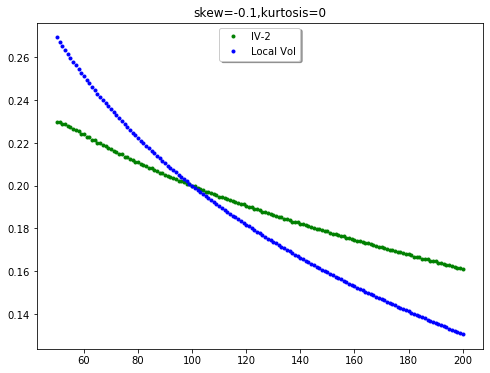

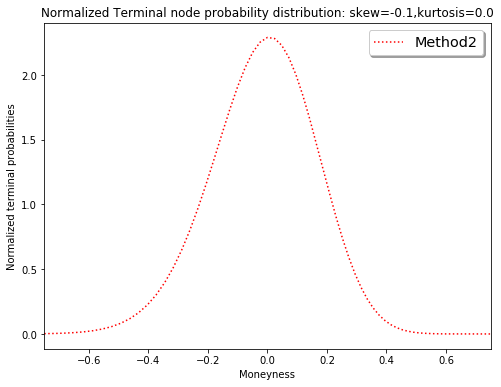

In [219]:
(test_entropy, test_positive, test_grids) = proportional_grids(quad_vol1,U,L,T,N,r,loop,c,skew,kurtosis)
prop_prob = prob_arr(test_grids,r,T,N,skew, kurtosis)
quad_IV3=[]
localvol=[]
Krange =np.linspace(50, 200, 151)
for K in Krange:
    C=optionPricer(K,test_grids,prop_prob)
    quad_IV3.append(IVofCall(C,S0*np.exp(r*T),r,K,T))
    localvol.append(vol(np.log(K),skew,kurtosis))
        
#plot IV
fig, ax2 = plt.subplots(figsize=(8,6))
ax2.plot(Krange, quad_IV3, 'g.',label = 'IV-2')
ax2.plot(Krange, localvol, 'b.',label = 'Local Vol')
legend = plt.legend(loc='upper center', shadow=True)
plt.title('skew=-0.1,kurtosis=0')
#final_logS(test_grids, vol, T, N, r, skew, kurtosis)


prob_flow3,nodes,skew, kurtosis = final_logS(test_grids, vol, T, N, r,skew, kurtosis),test_grids,-0.1,0
nor_prob3 = normalized_prob(prob_flow3,nodes,skew,kurtosis)


fig, ax4 = plt.subplots(figsize=(8,6))
ax4.plot(test_grids[1:-1]-np.log(100), nor_prob3,'r:',label = 'Method2') # pr1/sum(pr1*detlax)
plt.xlim(-0.75, 0.75)
plt.ylabel('Normalized terminal probabilities')
plt.xlabel('Moneyness')
plt.title("Normalized Terminal node probability distribution: skew=%.1f,kurtosis=%.1f"%(skew,kurtosis))
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')


### Observation:
1. Compares to method1's probability distribution, method2's distribution has a higher weight in pm. 
2. Method2's IV curve is almost identical to method1's IV curve. 
3. Terminal node distribution is more concentrated in the peak and less spread out at wings.

#### Error checking

In [220]:
def error_checking():
    vol, S0, T, N, r,skew,kurtosis = quad_vol, 100, 0.75, 1200, 0, -0.1,0
    K = np.linspace(30, 200, 151)
    grids, vol, r, K= quad_grids,quad_vol,0,K
    (quad_price, quad_IV) = IV_curve_call(grids, vol, r, K, T, N, skew,kurtosis)
    error = np.round(quad_price,7) - np.round(BS_call_price(sigma, S0, r, K, T),7)
    return error

## Section 3.3: Comparison between Method1 and Method2

Text(0.5, 1.0, 'skew=-0.1,kurtosis=0')

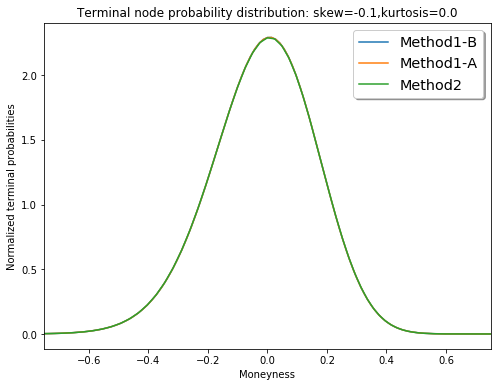

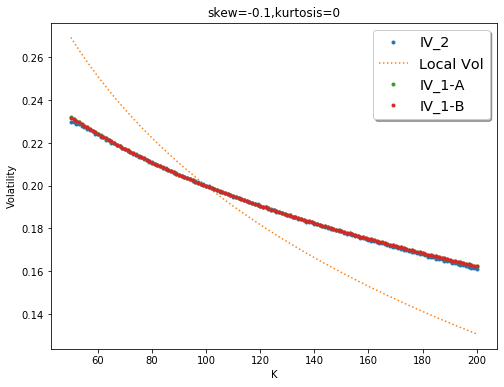

In [221]:
fig, ax5 = plt.subplots(figsize=(8,6))
ax5.plot(quad_grids[1:-1]-np.log(100), nor_prob,'-',label = 'Method1-B') 
ax5.plot(quad_grids_2[1:-1]-np.log(100), nor_prob2,'-', label = 'Method1-A')
ax5.plot(test_grids[1:-1]-np.log(100), nor_prob3,'-',label = 'Method2')
plt.xlim(-0.75, 0.75)
plt.ylabel('Normalized terminal probabilities')
plt.xlabel('Moneyness')
plt.title("Terminal node probability distribution: skew=%.1f,kurtosis=%.1f"%(skew,kurtosis))
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')

fig, ax6 = plt.subplots(figsize=(8,6))
ax6.plot(Krange, quad_IV3, '.',label = 'IV_2')
ax6.plot(Krange, localvol, ':',label = 'Local Vol')
ax6.plot(Krange, quad_IV_2, '.',label = 'IV_1-A')
ax6.plot(Krange, quad_IV, '.',label = 'IV_1-B')
plt.ylabel('Volatility')
plt.xlabel('K')
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.title('skew=-0.1,kurtosis=0')

### Observation:

1. The imlied vol curve and normalized terminal node distribution are nearly identical. 
   It's likely that these two methods are very similar to each other.

## Section 4.1: Shocking kurtosis. 

### Fix skew = -0.1 and adjust kurtosis.

In [222]:
def normalize_terminal_prob(nodes, probs):
    new_probs = probs[1:-1]
    u = nodes[:-2]
    m = nodes[1:-1]
    d = nodes[2:]
    new_probs = new_probs / (u - d)
    new_probs = new_probs / np.sum(new_probs)
    var = np.sum(nodes ** 2 * probs)
    std = np.sqrt(var)
    # moneyness, standard deviation, normalize probs
    return m, m / std, new_probs
  

def fix_skew(skew):
    x = [-0.2,0,0.2]
    prob_list = []
    grids_list = []
    for i in range(len(x)):
        skew,kurtosis = skew,x[i]
        vol, S0, T, N, r = quad_vol, 100, 0.75, 200, 0
        K =np.linspace(50, 200, 151)
        (quad_pm, quad_grids) = dynamic_integral_grids(vol, S0, T, N, r,skew,kurtosis)
        (quad_price_2, quad_IV) = IV_curve_call(quad_grids, vol, r, K, T, N,skew,kurtosis)
        
        #plot IV
        fig, ax2 = plt.subplots(figsize=(8,6))
        ax2.plot(K, quad_IV, 'r.',label = 'IV_1-B')
        ax2.plot(K, quad_vol(np.log(K),skew,kurtosis), 'b.',label = 'Local Vol')
        legend = plt.legend(loc='upper center', shadow=True)
        plt.title('skew=-0.1,kurtosis=%.1f'%kurtosis)
        
        #plot node distribution
        grids, vol= quad_grids,quad_vol
        temp_prob = final_logS(grids, vol, T, N, r,skew,kurtosis)
        prob_list.append(temp_prob)
        grids_list.append(grids)
   
    f, ax = plt.subplots(2, 1, figsize=(10,16))
    mon, std, prb = normalize_terminal_prob(grids_list[0]-np.log(100), prob_list[0])
    ax[0].plot(mon, prb, 'r-',label = 'kurtosis = %.1f'%x[0])
    ax[1].plot(std, prb, 'r-',label = 'kurtosis = %.1f'%x[0])
    mon, std, prb = normalize_terminal_prob(grids_list[1]-np.log(100), prob_list[1])
    ax[0].plot(mon, prb, 'g-',label = 'kurtosis = %.1f'%x[1])
    ax[1].plot(std, prb, 'g-',label = 'kurtosis = %.1f'%x[1])
    mon, std, prb = normalize_terminal_prob(grids_list[2]-np.log(100), prob_list[2])
    ax[0].plot(mon, prb, 'b-',label = 'kurtosis = %.1f'%x[2])
    ax[1].plot(std, prb, 'b-',label = 'kurtosis = %.1f'%x[2])

      
    ax[0].legend(loc='upper left', shadow=True)
    ax[0].set_title('Integrated graph, terminal probs by moneyness: shock kurtosis')
    ax[0].set_xlim(-0.75,0.75)
    ax[0].set_ylabel('adjusted terminal probabilities')
    ax[0].set_xlabel('Moneyness')
    
    ax[1].legend(loc='upper left', shadow=True)
    ax[1].set_title('Integrated graph, terminal probs by standard deviation: shock kurtosis')
    ax[1].set_xlim(-4,4)
    ax[1].set_ylabel('adjusted terminal probabilities')
    ax[1].set_xlabel('Standard Deviation')

 
    

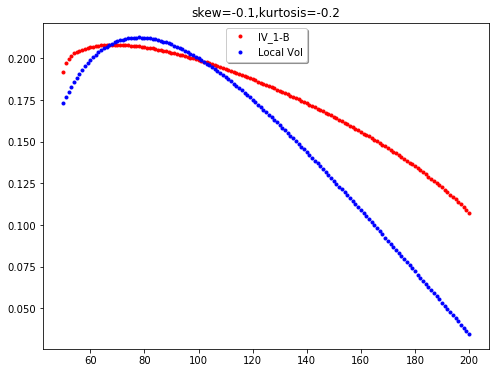

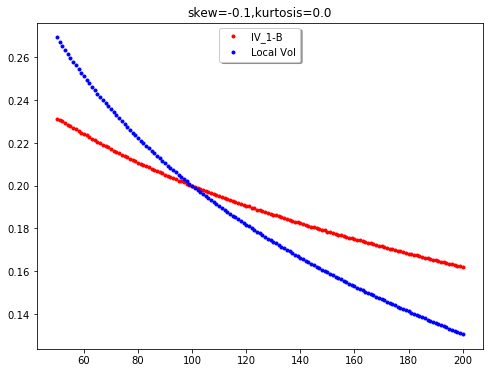

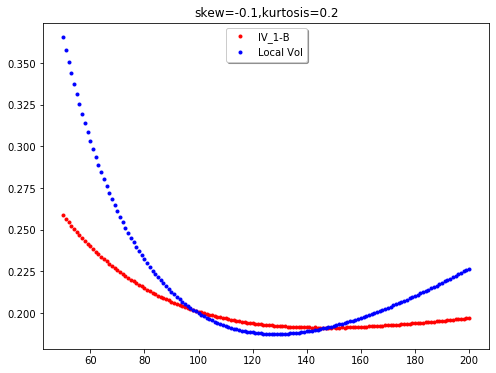

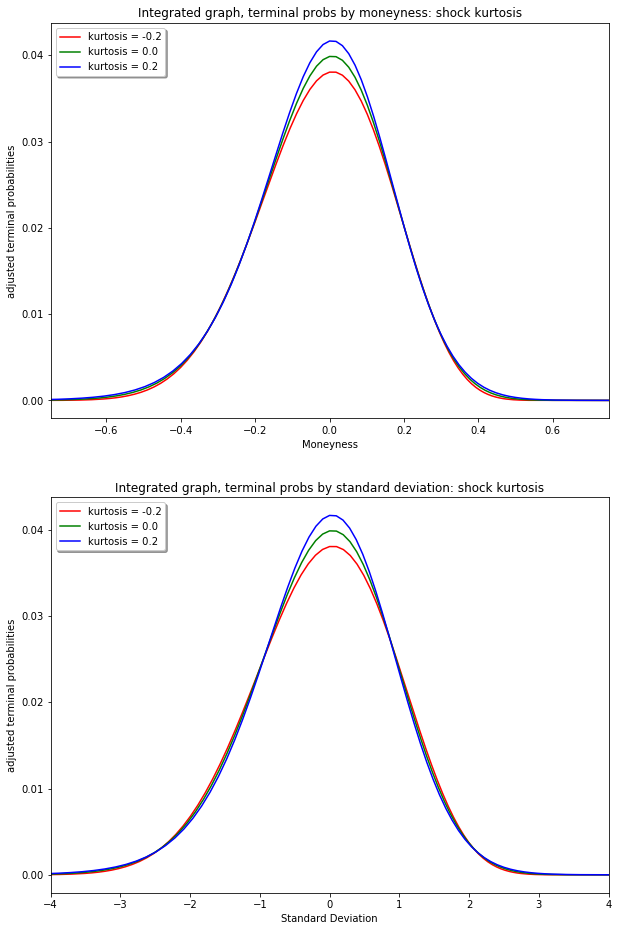

In [223]:
fix_skew(-0.1)

### Observation:

1. In this section, we want to investigate the effect of changing skewness and kurtosis. We first fix the skew to be -0.1. Let kurtosis be -0.2,0,0.2 respectively. Using method 1-B, we obtain three plots. As we can see that when kurtosis is negative, the local vol is not a smile as well as implied vol. In reality, the volatility of option on future would not be the greatest when ATM. Thus this does not really make sense when kurtosis is negative. When kurtosis is 0, this becomes a volatility skew. And when kurtosis is positive, this is a volatility smile. Since implied vol in some sense is the average of local vol, all graphs have a more flattened implied vol curve than local vol curve.
2. Node distribution: higher kurtosis will result in a higher peak. Note that in this plot it apears that the blue curve's area
   is larger than other curves. However, it is caused by the fact that it has fewer points, thus a higher density function. 

## Section 4.2: Shocking Skew

### Fix kurtosis = 0.1 and adjust skew.

In [224]:
def fix_kurtosis(kurtosis):
    x = [-0.3,-0.1,0,0.1,0.3]
    prob_list = []
    grids_list = []
    for i in range(len(x)):
        skew, kurtosis = x[i],kurtosis
        vol, S0, T, N, r = quad_vol, 100, 0.75, 200, 0
        K =np.linspace(50, 200, 151)
        (quad_pm, quad_grids) = dynamic_integral_grids(vol, S0, T, N, r,skew, kurtosis)
        (quad_price_2, quad_IV) = IV_curve_call(quad_grids, vol, r, K, T, N,skew, kurtosis)
        (quad_pm_2, quad_grids_2) = dynamic_integral_grids_2(vol, S0, T, N, r,skew, kurtosis)
        (quad_price, quad_IV_2) = IV_curve_call(quad_grids_2, vol, r, K, T, N, skew, kurtosis)
        
        #plot IV
        
        fig, ax2 = plt.subplots(figsize=(8,6))
        ax2.plot(K, quad_IV_2, 'g.',label = 'IV_1-B')
        ax2.plot(K, quad_vol(np.log(K),skew, kurtosis), 'b.',label = 'Local Vol')
        legend = plt.legend(loc='upper right', shadow=True)
        plt.title('skew=%.1f,kurtosis=0.1'%skew)

        #plot node distribution
        grids, vol= quad_grids,quad_vol
        temp_prob = final_logS(grids, vol, T, N, r,skew, kurtosis)
        prob_list.append(temp_prob)
        grids_list.append(grids)
        
        #plot integrated graph

    f, ax = plt.subplots(2, 1, figsize=(10,16))
    for i in range(5):
        mon, std, prb = normalize_terminal_prob(grids_list[i]-np.log(100), prob_list[i])
        ax[0].plot(mon, prb, '-',label = 'skew = %.1f'%x[i])
        ax[1].plot(std, prb, '-',label = 'skew = %.1f'%x[i])
    ax[0].legend(loc='upper left', shadow=True)
    ax[0].set_title('Integrated graph terminal probs by moneyness: Shock skew')
    ax[0].set_xlim(-1,1)
    ax[1].legend(loc='upper left', shadow=True)
    ax[1].set_title('Integrated graph terminal probs by standard deviation: Shock skew')
    ax[1].set_xlim(-4,4)
    

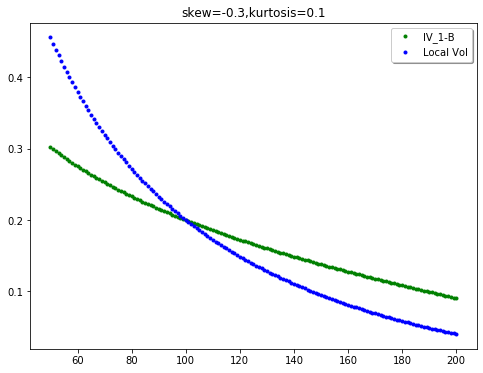

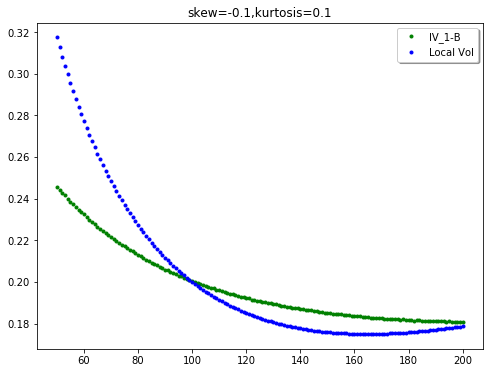

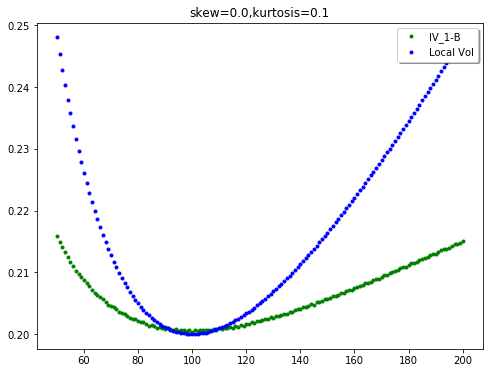

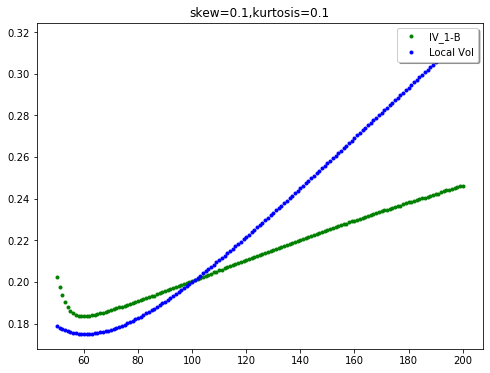

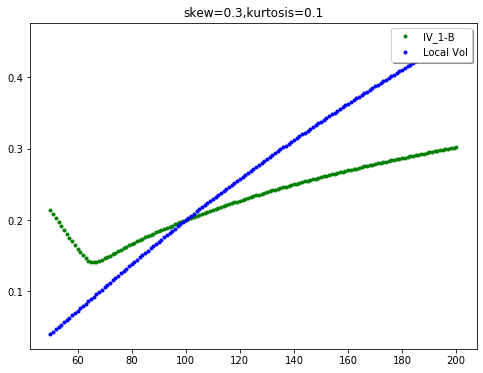

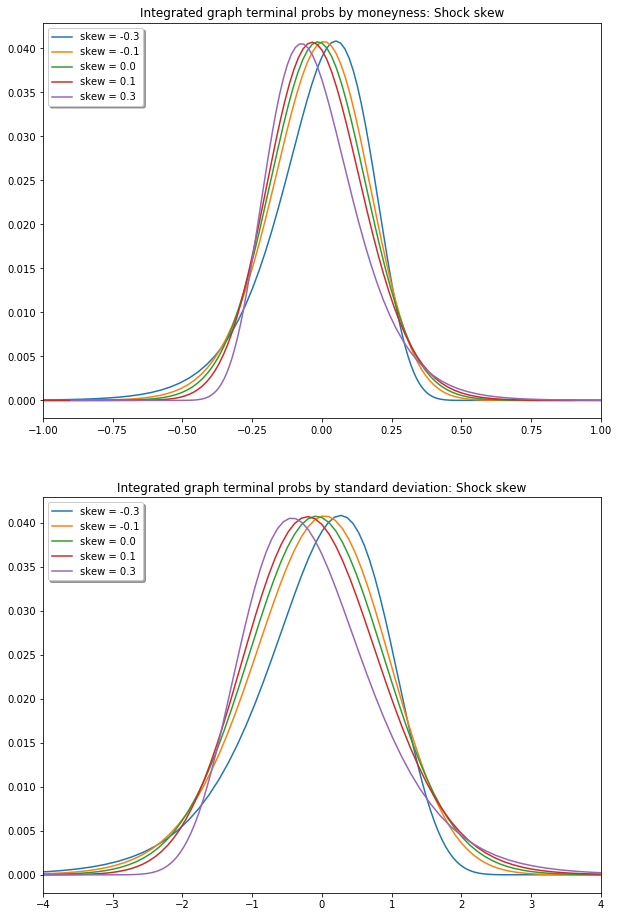

In [225]:
fix_kurtosis(0.1)

### Observation:
1. Deep ITM options have very high IV. This is because they have very small vega. 
2. Now we fix the kurtosis to be 0.1. Let skewness be -0.3,-0.1,0,0.1,0.3 respectively. Using method 1-B, we obtained five plots. As we can see that when skewness is 0, the local vol is a smile as well as implied vol. When skewness is negative, it has a downside trending as stock price goes up. When skewness is positive, it has a upside trending 


## Section 5: Limitations and Future Improvements


Local volatility is a quadratic function of S. In the future, we would like to include time variation and try to model stocastic local volatility. 